# Finding the Optimal Coin to Withdraw from Kraken

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import os
import sys
import re
import json
import math

# Scraping the withdrawal fees on Kraken

In [17]:
# URL of the Kraken withdrawal fees page
url = "https://support.kraken.com/hc/en-us/articles/360000767986-Cryptocurrency-withdrawal-fees-and-minimums"

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract the data
table = soup.find('table')
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    columns = row.find_all('td')
    coin_name = columns[0].text.strip()
    withdrawal_fee = columns[1].text.split()[0].strip()
    
    # Handling the "FREE" fee
    if withdrawal_fee == "FREE":
        fee_value = 0.0
    else:
        fee_value = float(withdrawal_fee.replace(',', ''))
    
    # Splitting the "Withdrawal minimum (including fee)" column
    minimum_with_fee = columns[2].text.split()
    if len(minimum_with_fee) > 1:
        ticker_symbol = minimum_with_fee[1].strip()
    else:
        ticker_symbol = "N/A"
    
    data.append([coin_name, fee_value, ticker_symbol])

df = pd.DataFrame(data, columns=['coin', 'withdrawal_fee', 'ticker_symbol'])
df


,coin,withdrawal_fee,ticker_symbol
0,0x,21.00000,ZRX
1,1inch,11.00000,1INCH
2,Aave,0.07300,AAVE
3,Aavegotchi,5.30000,GHST
4,Acala,0.15000,ACA
...,...,...,...
247,Wrapped Ether,0.00300,WETH
248,Wrapped Axelar,11.00000,WAXL
249,Yearn Finance,0.00064,YFI
250,Yield Guild Games,21.00000,YGG


# Fetching the current coin prices

In [19]:
base_url = "https://api.kraken.com/0/public/Ticker"

# A helper function to get the price for a given ticker symbol
def get_price(ticker_symbol):
try:
    response = requests.get(base_url, params={'pair': ticker_symbol + 'USD'})
    data = response.json()
    # Extracting the current price from the API response
    price = float(data['result'][f'X{ticker_symbol}ZUSD']['c'][0])
    return price
except:
    # Return None if there's any issue fetching the price
    return None

# Apply the helper function to the 'Ticker Symbol' column and create a new column 'Current Price'
df['Current Price'] = df['ticker_symbol'].apply(get_price)
df

,coin,withdrawal_fee,ticker_symbol,Current Price
0,0x,21.00000,ZRX,NaN
1,1inch,11.00000,1INCH,NaN
2,Aave,0.07300,AAVE,NaN
3,Aavegotchi,5.30000,GHST,NaN
4,Acala,0.15000,ACA,NaN
...,...,...,...,...
247,Wrapped Ether,0.00300,WETH,NaN
248,Wrapped Axelar,11.00000,WAXL,NaN
249,Yearn Finance,0.00064,YFI,NaN
250,Yield Guild Games,21.00000,YGG,NaN


In [21]:
import time

base_url = "https://api.kraken.com/0/public/Ticker"

def get_price(ticker_symbol):
    time.sleep(1)  # Introducing a delay of 1 second between requests
    try:
        response = requests.get(base_url, params={'pair': ticker_symbol + 'USD'})
        data = response.json()
        # This approach tries to dynamically get the key for the pair from the response
        key = list(data['result'].keys())[0]
        price = float(data['result'][key]['c'][0])
        return price
    except Exception as e:
        print(f"Error for {ticker_symbol}: {e}")
        return None

df['Current Price'] = df['ticker_symbol'].apply(get_price)


Error for AVT: 'result'
Error for GENS: 'result'
Error for OTP: 'result'
Error for PICA: 'result'
Error for SXP: 'result'
Error for WETH: 'result'


In [24]:
df.dropna(inplace=True)

In [26]:
#rename Current Price to current_price
df.rename(columns={'Current Price': 'current_price'}, inplace=True)
df

,coin,withdrawal_fee,ticker_symbol,current_price
0,0x,21.00000,ZRX,0.1980
1,1inch,11.00000,1INCH,0.2400
2,Aave,0.07300,AAVE,63.9600
3,Aavegotchi,5.30000,GHST,0.7576
4,Acala,0.15000,ACA,0.0450
...,...,...,...,...
246,Wrapped Bitcoin,0.00020,WBTC,27316.2000
248,Wrapped Axelar,11.00000,WAXL,0.3358
249,Yearn Finance,0.00064,YFI,5104.0000
250,Yield Guild Games,21.00000,YGG,0.2200


In [27]:
#withdrawal fee in USD
df['withdrawal_fee_usd'] = df['withdrawal_fee'] * df['current_price']
df

,coin,withdrawal_fee,ticker_symbol,current_price,withdrawal_fee_usd
0,0x,21.00000,ZRX,0.1980,4.15800
1,1inch,11.00000,1INCH,0.2400,2.64000
2,Aave,0.07300,AAVE,63.9600,4.66908
3,Aavegotchi,5.30000,GHST,0.7576,4.01528
4,Acala,0.15000,ACA,0.0450,0.00675
...,...,...,...,...,...
246,Wrapped Bitcoin,0.00020,WBTC,27316.2000,5.46324
248,Wrapped Axelar,11.00000,WAXL,0.3358,3.69380
249,Yearn Finance,0.00064,YFI,5104.0000,3.26656
250,Yield Guild Games,21.00000,YGG,0.2200,4.62000


In [28]:
df.describe()


,withdrawal_fee,current_price,withdrawal_fee_usd
count,246.000000,2.460000e+02,246.000000
mean,6019.271391,5.132379e+02,2.306721
std,68601.890197,3.462016e+03,2.272752
min,0.000000,3.700000e-07,0.000000
25%,0.200000,8.663900e-02,0.125876
50%,2.650000,4.184000e-01,2.335800
75%,16.500000,1.800525e+00,3.632145
max,1000000.000000,2.731620e+04,14.648000


# Top 10 Coins with the Highest and Lowest Withdrawal Fees in USD:

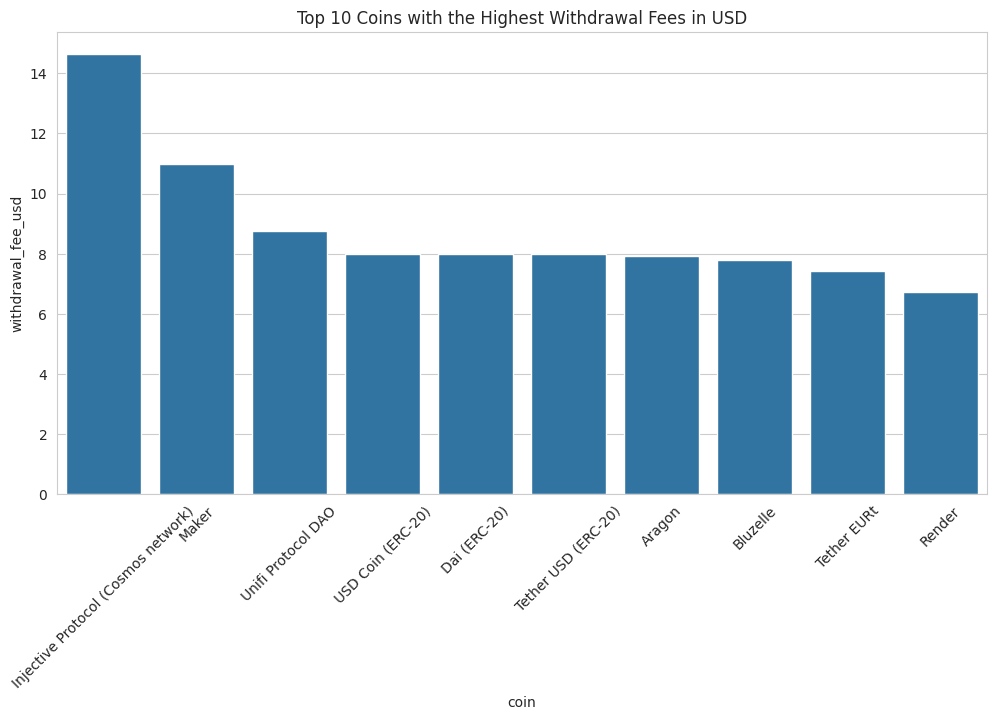

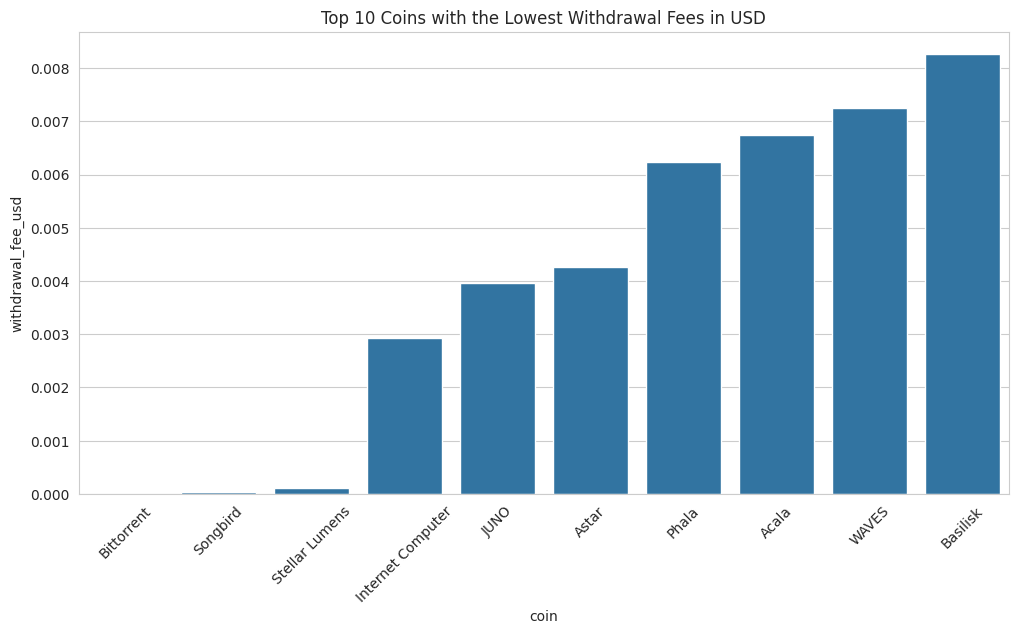

In [29]:
sns.set_style("whitegrid")

# Top 10 coins with the highest withdrawal fees in USD
top_10_highest_fees = df.sort_values(by="withdrawal_fee_usd", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="coin", y="withdrawal_fee_usd", data=top_10_highest_fees)
plt.title("Top 10 Coins with the Highest Withdrawal Fees in USD")
plt.xticks(rotation=45)
plt.show()

# Top 10 coins with the lowest withdrawal fees in USD
top_10_lowest_fees = df[df["withdrawal_fee_usd"] > 0].sort_values(by="withdrawal_fee_usd").head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="coin", y="withdrawal_fee_usd", data=top_10_lowest_fees)
plt.title("Top 10 Coins with the Lowest Withdrawal Fees in USD")
plt.xticks(rotation=45)
plt.show()


## Distribution of Withdrawal Fees:

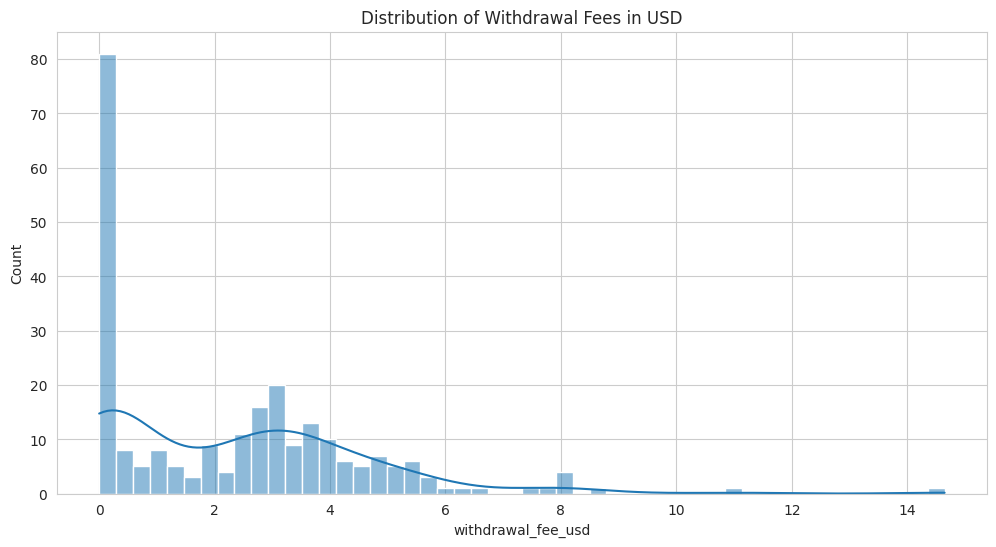

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(df["withdrawal_fee_usd"], bins=50, kde=True)
plt.title("Distribution of Withdrawal Fees in USD")
plt.show()


## Relationship between Coin Price and Withdrawal Fee:

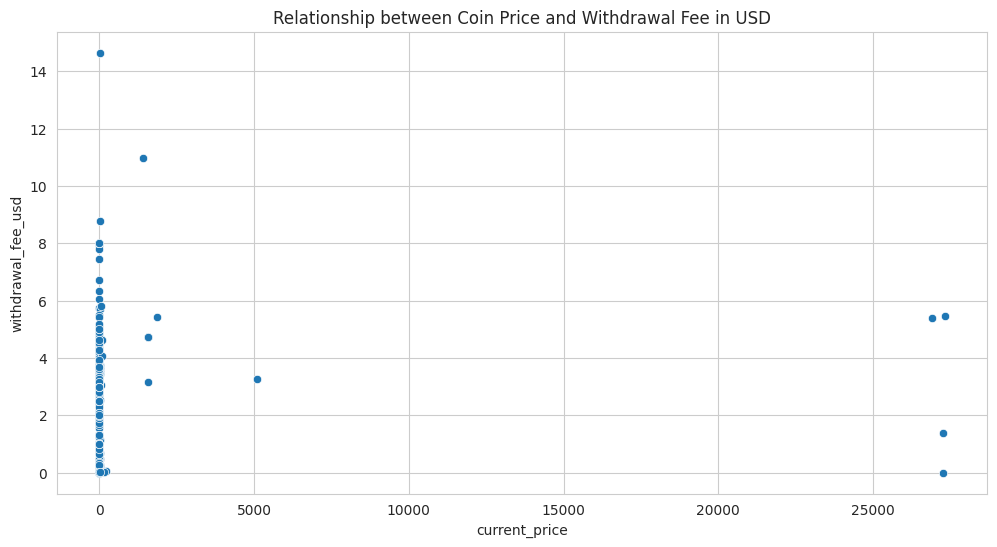

In [31]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="current_price", y="withdrawal_fee_usd", data=df)
plt.title("Relationship between Coin Price and Withdrawal Fee in USD")
plt.show()


In [33]:
cheapest_coin = df[df["withdrawal_fee_usd"] == df["withdrawal_fee_usd"].min()]
cheapest_coin

,coin,withdrawal_fee,ticker_symbol,current_price,withdrawal_fee_usd
38,Bitcoin (Lightning Network),0.0,BTC,27271.0,0.0
